In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from datetime import datetime
from packaging import version

%load_ext tensorboard

In [2]:
import tensorflow.keras as keras

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras import losses
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.models import load_model

from keras.layers.merge import concatenate

from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [3]:
import tensorflow as tf

print(tf.__version__)

1.14.0


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

samples= 5
tipo = 3    # np.random.randint(4)
index_image = np.random.randint(100000)  


# ========== EXTRACCIÓN DE DATOS ==============
archivo = open('./dataset/HiTS2013_100k_samples(4_channels)_images_labels.pkl',"rb")
example_dict= pickle.load(archivo)
print(example_dict['labels'].shape)
print(example_dict['images'].shape)

L=example_dict['labels'].shape[0] #numero total de imagenes

input_images=example_dict['images'][:40000, :, :, tipo]
input_images=np.expand_dims(input_images, axis=-1)

#padded
input_images=np.pad(input_images, ((0,0),(2,1), (2,1), (0, 0)), 'constant')


print(input_images.shape)

(100000,)
(100000, 21, 21, 4)
(40000, 24, 24, 1)


In [5]:
#normalization
def normalize(processed):
    ####### calculate global mean and standard deviation
    mean, std = processed.mean(), processed.std()
    #print('Mean: %.3f, Standard Deviation: %.3f' % (mean, std))
    ####### global standardization of pixels
    processed = (processed - mean) / std
    ####### clip pixel values to [-1,1]
    processed = np.clip(processed, -1.0, 1.0)
    ####### shift from [-1,1] to [0,1] with 0.5 mean
    processed = (processed + 1.0) / 2.0
    #print('after normalization')
    #print('Valor máximo :', processed.max())
    #print('Valor mínimo :', processed.min())
    return processed

In [6]:
#preprocess 3D to 2D

def preprocessar_2d(ximg):

    print(ximg.shape)
    x= np.squeeze(ximg, axis=2)  
    print('---->', x.shape)

    
    return x

shape de mapas de oclusion: (40000, 21, 21, 1)
(21, 21, 1)
----> (21, 21)
Nº labels:  40000


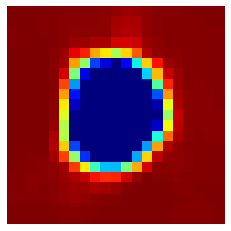

In [7]:
%matplotlib inline

imagem=30000      #Choose image to visualize


archivo_occluded = open('./dataset/OCmaps_F.pkl',"rb")
OCmaps= pickle.load(archivo_occluded)



OCimg=OCmaps["image"]

print("shape de mapas de oclusion:", OCimg.shape)
input_shape=OCimg[imagem].shape
OCimg=preprocessar_2d(OCimg[imagem])


labelOcc=OCmaps["label"]
labelOcc=labelOcc[:OCmaps["image"].shape[0]]

n_labels=  labelOcc.shape[0]

#print("labels shape: ", labelOcc.shape)
print("Nº labels: ", n_labels)


plt.imshow(OCimg, cmap='jet')                #[2:19, 2:19])
plt.axis("off")


plt.show()




(40000, 24, 24, 1)
input shape:  (24, 24, 1)
(24, 24, 1)
----> (24, 24)


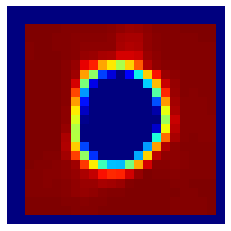

In [8]:
#padding images

occ_img_padded=np.pad(OCmaps["image"], ((0,0),(2,1), (2,1), (0, 0)), 'constant')
print(occ_img_padded.shape)
input_shape=occ_img_padded[imagem].shape
print('input shape: ', input_shape)

plt.imshow(preprocessar_2d(occ_img_padded[imagem]), cmap='jet')                #[2:19, 2:19])
plt.axis("off")


plt.show()

In [9]:
encoding_dim = 34

inputA = Input(shape=input_shape)#(21,21,1))
#####inputB = Input(shape=(1,))
inputB = Input(shape=(2,))
#conv
encoded= Conv2D(32, kernel_size=(4, 4), padding='same', strides=(1, 1),
                     input_shape=input_shape)(inputA)
#conv
encoded=Conv2D(32, kernel_size=(3, 3), padding='same', strides=(1, 1))(encoded)
#max-pool
encoded=MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(encoded)
#conv
encoded=Conv2D(64, kernel_size=(3, 3), padding='same', strides=(1, 1))(encoded)
#conv
encoded=Conv2D(64, kernel_size=(3, 3), padding='same', strides=(1, 1))(encoded)
#conv
encoded=Conv2D(64, kernel_size=(3, 3), padding='same', strides=(1, 1))(encoded)             
#max-pool
encoded=MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(encoded)
    
encoded=Flatten()(encoded)
    
encoded=Dense(encoding_dim, activation='softmax')(encoded)

#
combined = concatenate([encoded, inputB])
#

decoded = Reshape((int((encoding_dim+2)**(1/2)),int((encoding_dim+2)**(1/2)),1))(combined)
####decoded = Reshape((int((encoding_dim+2)**(1/2)),int((encoding_dim+2)**(1/2)),1))(combined)

#conv
decoded = Conv2D(64, kernel_size=(3, 3), padding='same', strides=(1, 1))(decoded)
#conv
decoded = Conv2D(64, kernel_size=(3, 3), padding='same', strides=(1, 1))(decoded)    
#conv
decoded = Conv2D(64, kernel_size=(3, 3), padding='same', strides=(1, 1))(decoded)   
#upsamp
decoded = UpSampling2D(size=(2, 2))(decoded)  
    
#conv
decoded = Conv2D(32, kernel_size=(3, 3), padding='same', strides=(1, 1))(decoded)
#conv
decoded = Conv2D(32, kernel_size=(4, 4), padding='same', strides=(1, 1))(decoded)
 
#upsamp
decoded = UpSampling2D(size=(2, 2))(decoded) 
    
#conv
decoded = Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same', strides=(1, 1))(decoded)

autoencoder = Model(inputs=[inputA, inputB], outputs=decoded)

###
classifier= load_model('supernova_class.model')
autoencoder.layers[1].set_weights(classifier.layers[0].get_weights())
autoencoder.layers[2].set_weights(classifier.layers[1].get_weights())
autoencoder.layers[4].set_weights(classifier.layers[3].get_weights())
autoencoder.layers[5].set_weights(classifier.layers[4].get_weights())
autoencoder.layers[6].set_weights(classifier.layers[5].get_weights())
###
    
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')










Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
# encoding_dim = 34

# inputA = Input(shape=input_shape)#(21,21,1))
# #####inputB = Input(shape=(1,))
# inputB = Input(shape=(2,))
# #conv
# encoded= Conv2D(32, kernel_size=(4, 4), padding='same', strides=(1, 1),
#                      input_shape=input_shape)(inputA)
# #conv
# encoded=Conv2D(32, kernel_size=(3, 3), padding='same', strides=(1, 1))(encoded)
# #max-pool
# encoded=MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(encoded)
# #conv
# encoded=Conv2D(64, kernel_size=(3, 3), padding='same', strides=(1, 1))(encoded)
# #conv
# encoded=Conv2D(64, kernel_size=(3, 3), padding='same', strides=(1, 1))(encoded)
# #conv
# encoded=Conv2D(64, kernel_size=(3, 3), padding='same', strides=(1, 1))(encoded)             
# #max-pool
# encoded=MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(encoded)
    
# encoded=Flatten()(encoded)
    
# encoded=Dense(encoding_dim, activation='softmax')(encoded)

# #
# combined = concatenate([encoded, inputB])
# #

# decoded = Reshape((int((encoding_dim+2)**(1/2)),int((encoding_dim+2)**(1/2)),1))(combined)
# ####decoded = Reshape((int((encoding_dim+2)**(1/2)),int((encoding_dim+2)**(1/2)),1))(combined)

# #conv
# decoded = Conv2D(64, kernel_size=(3, 3), padding='same', strides=(1, 1))(decoded)
# #conv
# decoded = Conv2D(64, kernel_size=(3, 3), padding='same', strides=(1, 1))(decoded)    
# #conv
# decoded = Conv2D(64, kernel_size=(3, 3), padding='same', strides=(1, 1))(decoded)   
# upsamp
# decoded = UpSampling2D(size=(2, 2))(decoded)  
    
# #conv
# decoded = Conv2D(32, kernel_size=(3, 3), padding='same', strides=(1, 1))(decoded)
# #conv
# decoded = Conv2D(32, kernel_size=(4, 4), padding='same', strides=(1, 1))(decoded)
 
# #upsamp
# decoded = UpSampling2D(size=(2, 2))(decoded) 
    
# #conv
# decoded = Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same', strides=(1, 1))(decoded)

# autoencoder = Model(inputs=[inputA, inputB], outputs=decoded)
    
# autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
# # 

In [11]:
autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 24, 24, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 24, 24, 32)   544         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 24, 24, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 12, 12, 32)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [12]:
#entrenar
epocas=1
batch=10
x_train=occ_img_padded

####labels_t=labelOcc
labels_t=keras.utils.to_categorical(labelOcc)

autoencoder.fit([input_images, labels_t], x_train,
                epochs=epocas,
                batch_size=batch,
                validation_split=0.25,
                shuffle=True,
                callbacks=[TensorBoard(log_dir='./tmp/autoencoder')])


Train on 30000 samples, validate on 10000 samples


Epoch 1/1
30000/30000 [==============================] - 102s 3ms/step - loss: 0.3691 - val_loss: 0.3562


In [13]:
def mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    
    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err

In [14]:
%tensorboard --logdir ./tmp/autoencoder

Reusing TensorBoard on port 6006 (pid 3071), started 14:13:48 ago. (Use '!kill 3071' to kill it.)

In [15]:
decoded_imgs = autoencoder.predict([input_images, labels_t], verbose=1)

40000/40000 [==============================] - 30s 743us/step


In [33]:
print(mse(x_train[imagem-2000], decoded_imgs[imagem-2000]))

0.0014489967282946539


(24, 24, 1)
----> (24, 24)


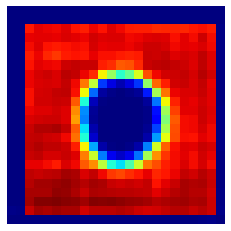

In [34]:
test=3

plt.imshow(preprocessar_2d(decoded_imgs[test]), cmap='jet')
plt.axis("off")


plt.show()

(24, 24, 1)
----> (24, 24)


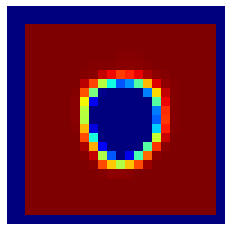

In [35]:
plt.imshow(preprocessar_2d(occ_img_padded[test]), cmap='jet')
plt.axis("off")


plt.show()

In [36]:
print(mse(x_train[test], decoded_imgs[test]))

0.004562328805771588


(24, 24, 1)
----> (24, 24)


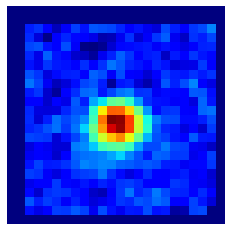

In [37]:
plt.imshow(preprocessar_2d(input_images[test]), cmap='jet')
plt.axis("off")


plt.show()

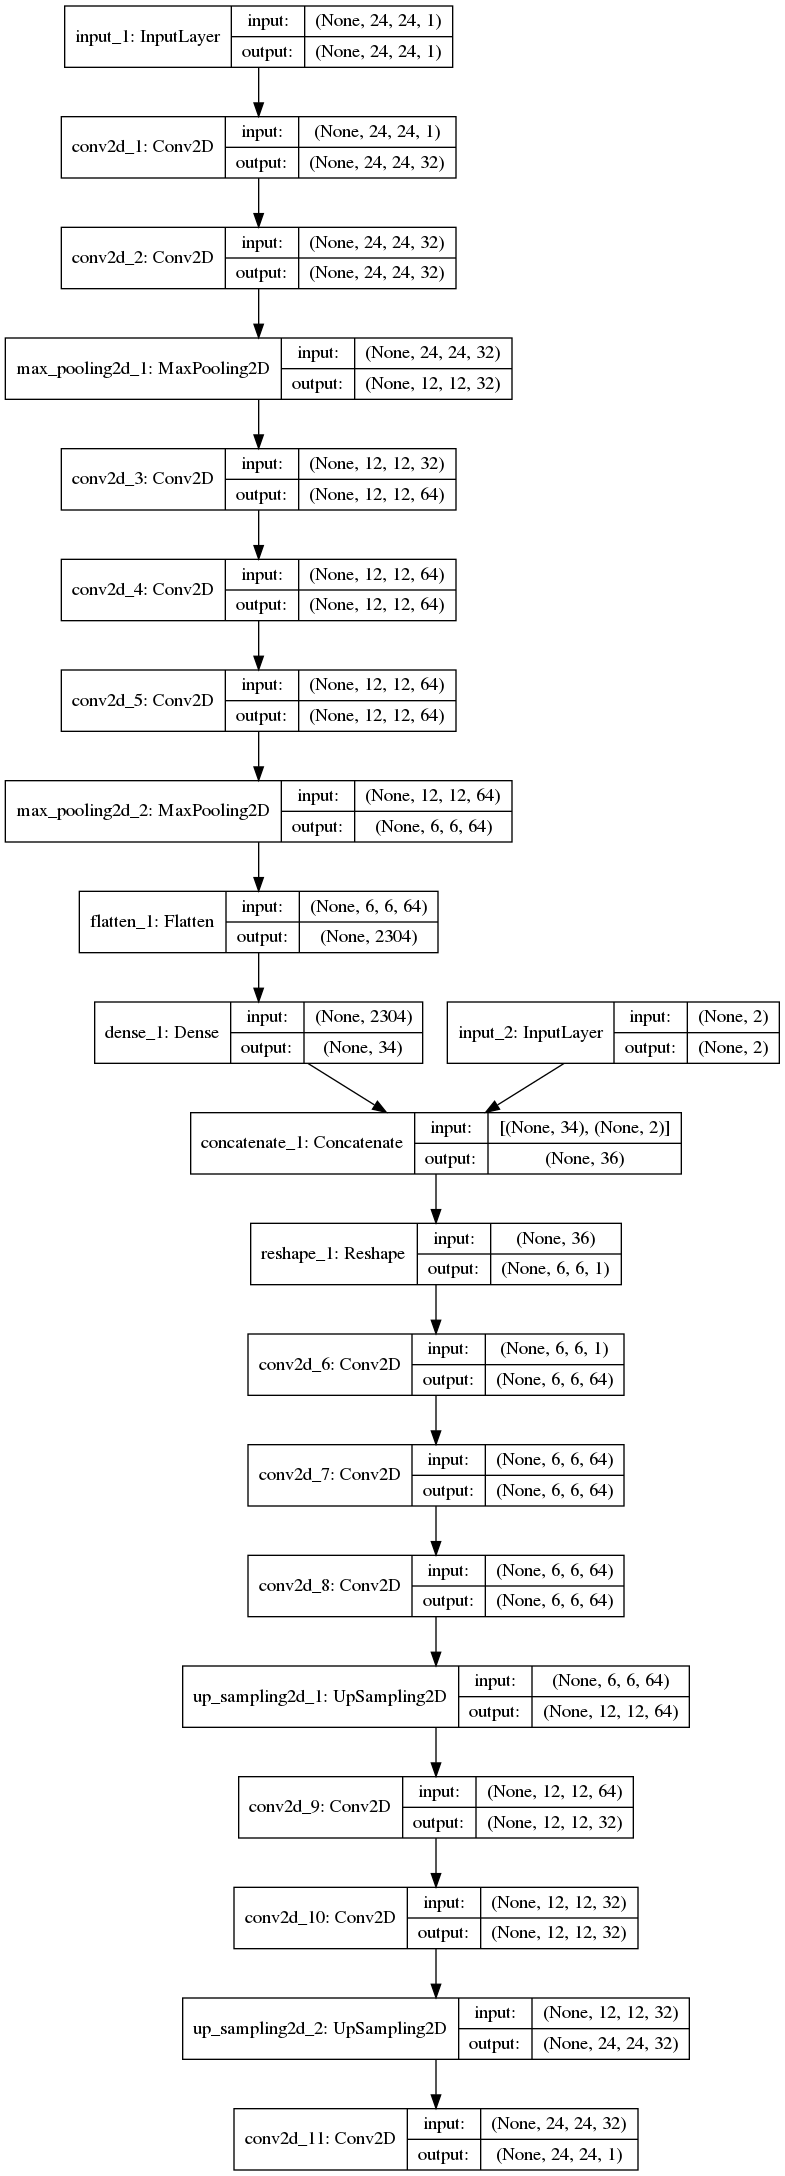

In [38]:
from keras.utils.vis_utils import plot_model
plot_model(autoencoder, show_shapes=True, show_layer_names=True, to_file='autoencoder_cond.png')
from IPython.display import Image
Image(retina=True, filename='autoencoder_cond.png')

In [39]:
encoder = Model(inputs=[inputA, inputB], outputs=combined)

In [40]:
encoded_imgs = encoder.predict([input_images, labels_t], verbose=1)

40000/40000 [==============================] - 16s 408us/step


In [41]:
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 24, 24, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 24, 24, 32)   544         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 24, 24, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 12, 12, 32)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [42]:
print(encoded_imgs.shape)

(40000, 36)


In [43]:
print(encoded_imgs[test])

[1.0107039e-08 9.9223163e-03 2.6783146e-08 2.0770759e-08 5.0433107e-09
 2.8104590e-09 1.9248837e-08 1.6102038e-04 2.1285549e-09 2.0791727e-08
 2.1453365e-08 1.5593765e-09 1.7496673e-08 9.8991603e-01 6.8743328e-10
 4.2777373e-09 3.9507024e-09 1.8549728e-09 4.1424279e-08 1.7230232e-09
 4.2224375e-12 3.4043939e-07 7.9175251e-08 5.6362054e-10 1.4487803e-08
 2.9076088e-09 1.1827911e-09 1.7589281e-09 6.2667727e-10 7.9846235e-10
 9.8669801e-09 3.0922109e-10 1.2754811e-10 4.2229757e-09 0.0000000e+00
 1.0000000e+00]


In [44]:
keras.utils.to_categorical(labelOcc)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [45]:
labelOcc.shape

(40000,)

In [46]:
def msefinal(model, input_images, output_images):
    # Ejemplo para MP3 - P1 :
    #   input_images - 4D - (40000,24,24,1) # El 24 es causado por el padding, las originales son de 21
    #   output_images - 4D - (40000,24,24,1) # El 24 es causado por el padding, las originales son de 21

    # El modelo predice la salida
    #prediction_output_images = model.predict([input_images, labels_t], verbose=1)  # 3D-(24,24,1)

    # Calcula el MSE producido por cada prediccion
    num_images = input_images.shape[0]
    error_list = []
    for indx in range(num_images):
        error = mse(input_images[indx], output_images[indx]) # prediction_output_images[indx])
        error_list.append(error)

    # Calcula el MSE promedio producido por el modelo
    suma_error = error_list[0]
    for error_value in error_list[1:]:
        suma_error += error_value
    ave_error = suma_error / num_images

    return ave_error

In [47]:
print('VALOR MSE: ', msefinal(autoencoder, x_train, decoded_imgs))

VALOR MSE:  0.012933055685117588


In [48]:
def graficoMSE(mse_train, mse_val):
    import matplotlib.pyplot as plt
    import numpy as np

    labels = ['Original', 'Corte 1', 'Corte 2']
    a = np.array([mse_train, mse_val])
    mse_max = np.nanmax(a)
    print(' mse_max : ', mse_max)

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width / 2, mse_val, width, label='Validacion')
    rects2 = ax.bar(x + width / 2, mse_train, width, label='Entrenamiento')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('MSE')
    ax.set_xlabel('Lugar de conexion')

    ax.set_title('MSE para autoencoders truncados')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(0, mse_max + mse_max/2.5)

    ax.legend()

    def autolabel(rects, x, i):
        # Attach a text label above each bar in *rects*, displaying its height.
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, x-i+5),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
            i*=4

    autolabel(rects1,3,0)
    autolabel(rects2,20,1)

    fig.tight_layout()
    plt.show()


 mse_max :  0.16455682149


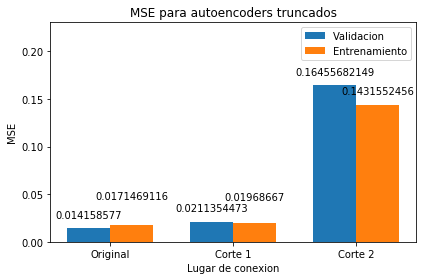

In [49]:
graficoMSE([0.0171469116, 0.01968667,0.1431552456],[0.014158577,0.0211354473,0.16455682149])